In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version >= 0.18
# for scikit-learn <= 0.17 use:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import random
from progressbar import ProgressBar

%matplotlib inline 

## Load Data

In [9]:
###############################################################################
###############################################################################
## HOG features 
#
###############################################################################
# 1.1. Data Loading
# vehicles images - data/vehicles/*/image*.png
# vehicles images - data/vehicles/*/*.png
# non-vehicle images - data/non-vehicles/*/image*.png 
# non-vehicle images - data/non-vehicles/*/extra*.png 
#
data_path = 'data/*vehicles/*/*'

vehicles = []
non_vehicles = []

bar = ProgressBar()

images_path = glob.glob(data_path)
for image_path in bar(images_path):
    if 'non' in image_path:
        non_vehicles.append(image_path)
    else:
        vehicles.append(image_path)

num_vehicles = len(vehicles)
num_non_vehicles = len(non_vehicles)

print('\nvehicle images: ', num_vehicles)        
print('non-vehicle images: ', num_non_vehicles)        

100% (17760 of 17760) |###################| Elapsed Time: 0:00:00 Time: 0:00:00



vehicle images:  8792
non-vehicle images:  8968


## Utiltiy function - Plot figures side by side

In [10]:
def plot_side_by_side(img1, title1, img2, title2, cmap=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
    
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=12)
    
    if cmap != None:
        ax2.imshow(img2, cmap=cmap)
    else:
        ax2.imshow(img2)
    ax2.set_title(title2, fontsize=12)
 

## Display a Vehicle and Non-vehicle Image

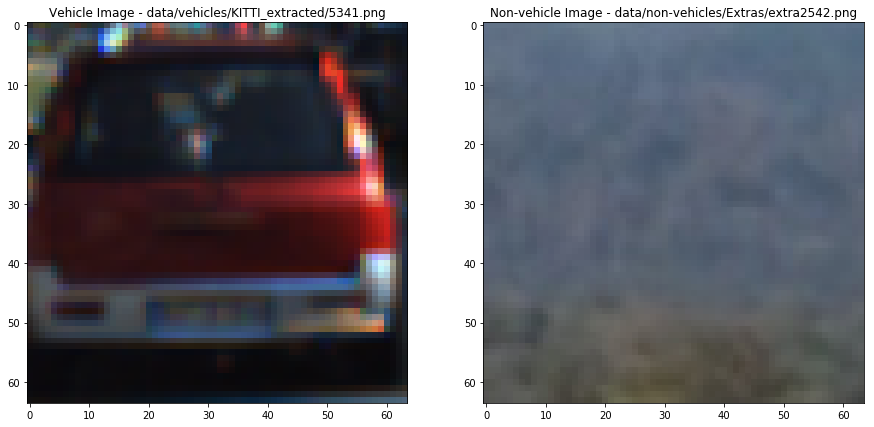

In [11]:
###############################################################################
# 1.2. Display vehicle and non-vehicle image
#
idx_vehicle = random.randint(0, num_vehicles)
idx_non_vehicle = random.randint(0, num_non_vehicles)

vehicle_img = mpimg.imread(vehicles[idx_vehicle])
non_vehicle_img = mpimg.imread(non_vehicles[idx_non_vehicle])

   
   
title1 = 'Vehicle Image - ' + vehicles[idx_vehicle]
title2 = 'Non-vehicle Image - ' + non_vehicles[idx_non_vehicle]
plot_side_by_side(vehicle_img, title1,
                  non_vehicle_img, title2)


## HOG features

In [12]:
###############################################################################
# 1.3. Explore color spaces and HOG parameters  
#

# -----------------------------------------------------------------------------
# Color classify
#
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# -----------------------------------------------------------------------------
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# -----------------------------------------------------------------------------
# HOG classify
#
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=False, feature_vector=feature_vec)
        return features

# -----------------------------------------------------------------------------
# Feature extraction for a single image
#
def test_hog_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):   
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
    
    if hog_channel == 'ALL':
        hog_features = []
        hog_images = []
        for channel in range(feature_image.shape[2]):
            feature, image = get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True) 
            hog_images.extend(image)
            hog_features.extend(feature)      
    else:
        hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            
    return hog_features, hog_images

## Test HOG features

/home/jaerock/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.03 Seconds to extract HOG features...


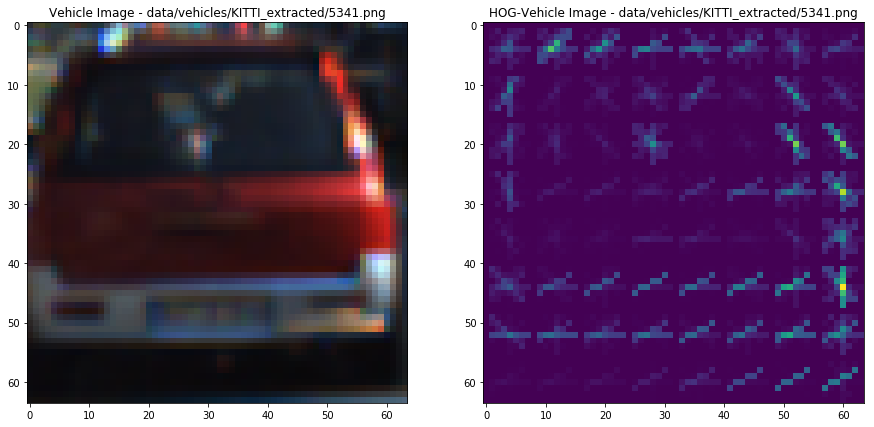

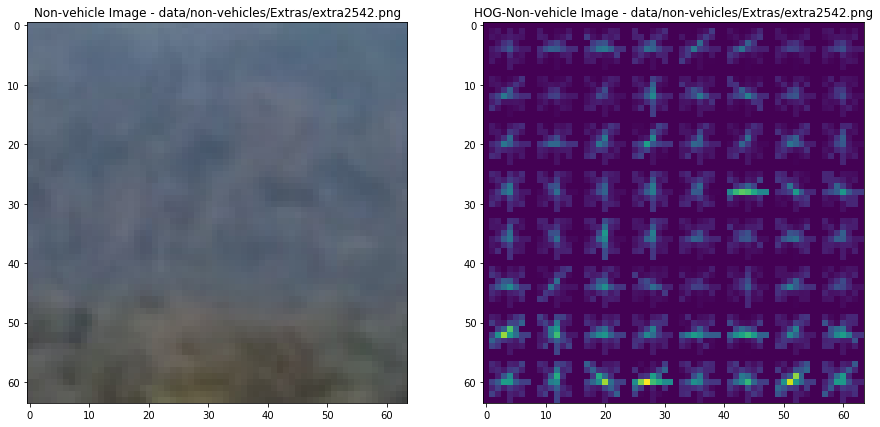

In [13]:
# -----------------------------------------------------------------------------
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time() 
vehicle_features, vehicle_features_img \
        = test_hog_features(vehicle_img, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
non_vehicle_features, non_vehicle_features_img \
        = test_hog_features(non_vehicle_img, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

plot_side_by_side(vehicle_img, title1, vehicle_features_img, 'HOG-' + title1)
plot_side_by_side(non_vehicle_img, title2, non_vehicle_features_img, 'HOG-' + title2)


## Test Support Vector Machine

In [14]:
###############################################################################
# 3. SVM 
#

# -----------------------------------------------------------------------------
# Feature extraction
#
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# -----------------------------------------------------------------------------
# SVM Training
t=time.time()
car_features = extract_features(vehicles, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_vehicles, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


# -----------------------------------------------------------------------------
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/jaerock/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


23.99 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1568
6.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9476
My SVC predicts:      [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
0.00143 Seconds to predict 10 labels with SVC


## Sliding Windows

In [15]:
###############################################################################
###############################################################################
## Sliding Window
##
#

###############################################################################
# 1. Sliding window search
#

# -----------------------------------------------------------------------------
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# -----------------------------------------------------------------------------
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if (x_start_stop[0] == None):
        x_start_stop[0] = 0
    if (x_start_stop[1] == None):
        x_start_stop[1] = img.shape[1]
    if (y_start_stop[0] == None):
        y_start_stop[0] = 0
    if (y_start_stop[1] == None):
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    xpixels = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ypixels = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    xlast_margin = np.int(xy_window[0]*xy_overlap[0])
    ylast_margin = np.int(xy_window[1]*xy_overlap[1])
    nx_win = np.int((xspan-xlast_margin)/xpixels)
    ny_win = np.int((yspan-ylast_margin)/ypixels)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for y in range(ny_win):
        for x in range(nx_win):
            # Calculate each window position
            x1 = x*xpixels + x_start_stop[0]
            y1 = y*ypixels + y_start_stop[0]
            x2 = x1 + xy_window[0]
            y2 = y1 + xy_window[1]
            # Append window position to list
            window_list.append(((x1,y1), (x2,y2)))
    # Return the list of windows
    return window_list


# -----------------------------------------------------------------------------
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# -----------------------------------------------------------------------------
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def multiple_img_features(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, 
                        augment=False):    

    bar = ProgressBar()
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in bar(files):
        image = mpimg.imread(file)
        feature = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(feature)

        if augment == True:
            image = cv2.flip(image, 1)
            feature = single_img_features(image, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            features.append(feature)
            
        # Return list of feature vectors
    return features


# -----------------------------------------------------------------------------
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


## Set SVC Parameters

In [16]:
# -----------------------------------------------------------------------------
# SVC parameters
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_size = (32,32) # (16, 16) # Spatial binning dimensions
hist_bins = 32 #16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


## SVC Training Function

In [17]:
# -----------------------------------------------------------------------------
# SVM training with new feature extraction function
def train_svc(vehicles, non_vhicles):
    t=time.time()
    car_features = multiple_img_features(vehicles, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = multiple_img_features(non_vehicles, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    return svc, X_scaler

## Set Sliding Window Parameters

In [18]:
# -----------------------------------------------------------------------------
# Sliding window parameters
y_start_stop = [720//2+40,720-100] #[400, 600] # Min and max in y to search in slide_window()
xy_window = (96, 96) #64, 64)
xy_overlap=(0.75, 0.75)


## My Own Function for Finding Cars

In [19]:
# -----------------------------------------------------------------------------
def find_cars_windows(image, svc, X_scaler):
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    return hot_windows


## Test find_cars_windows with Test Images

N/A% (0 of 8792) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/jaerock/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100% (8792 of 8792) |#####################| Elapsed Time: 0:00:24 Time: 0:00:24
100% (8968 of 8968) |#####################| Elapsed Time: 0:00:24 Time: 0:00:24


49.16 Seconds to extract HOG features...
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4140
7.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9862


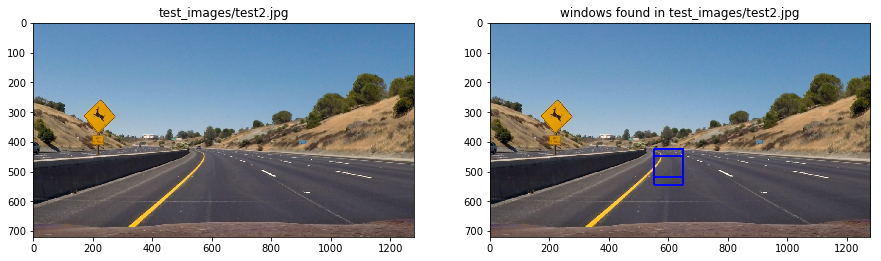

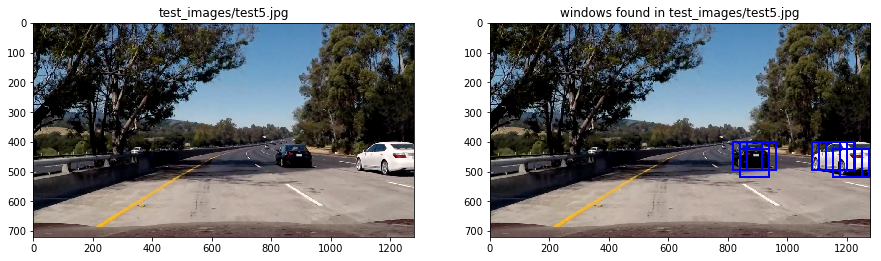

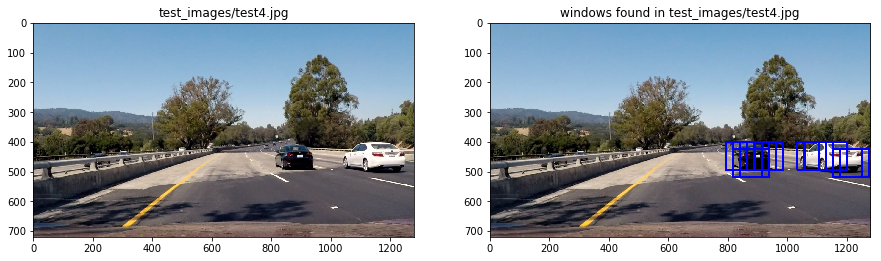

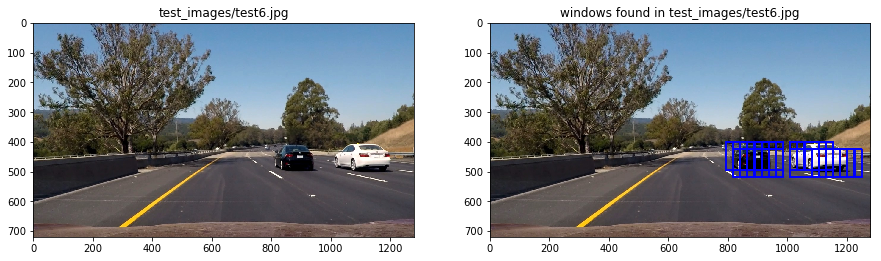

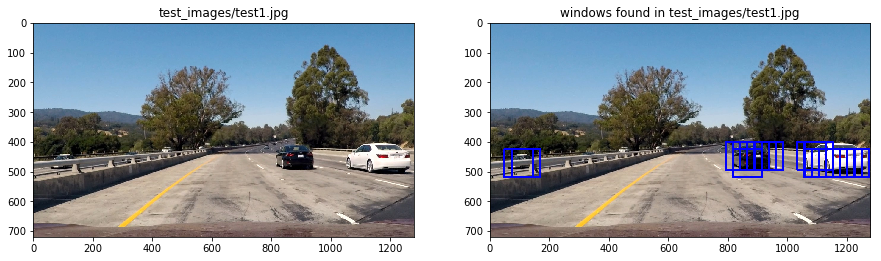

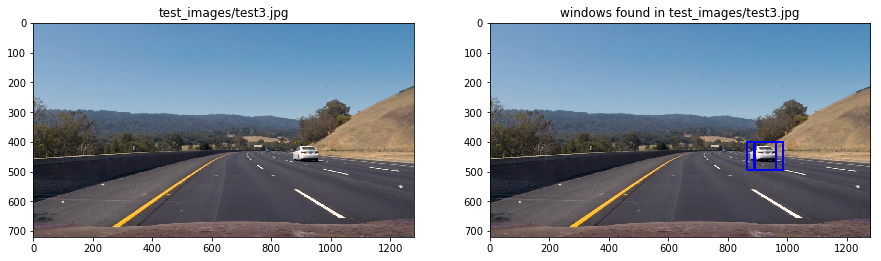

In [20]:
# -----------------------------------------------------------------------------

svc, X_scaler = train_svc(vehicles, non_vehicles)

test_images_path = 'test_images/test*.jpg'

for image_path in glob.glob(test_images_path):
    image = mpimg.imread(image_path)
    draw_image = np.copy(image)

    hot_windows = find_cars_windows(image, svc, X_scaler)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    title1 = image_path
    title2 = 'windows found in ' + image_path
    plot_side_by_side(image, title1, window_img, title2)


## HOG Sub-Sampling Window Search

In [21]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Hog sub-sampling window search
    
# -----------------------------------------------------------------------------
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# -----------------------------------------------------------------------------
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img    
    

## Test find_cars with HOG Sub-Sampling Window Search

/home/jaerock/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


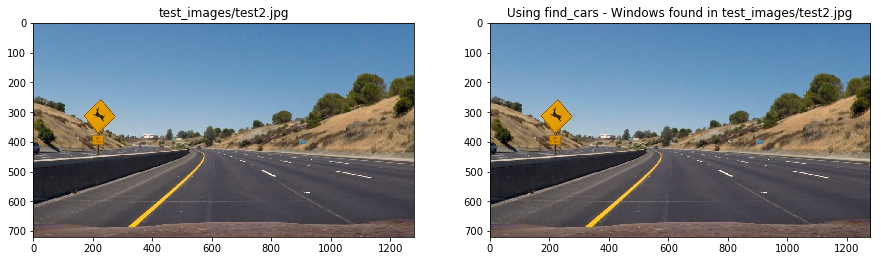

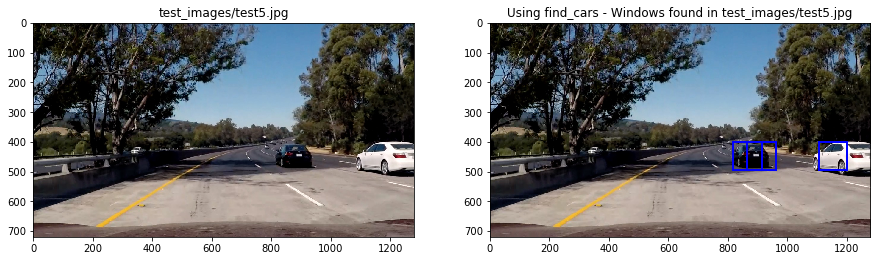

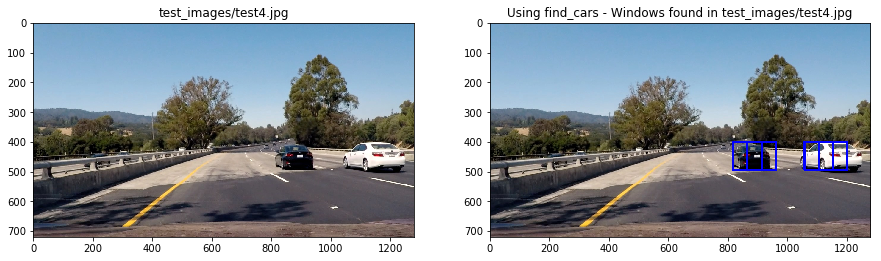

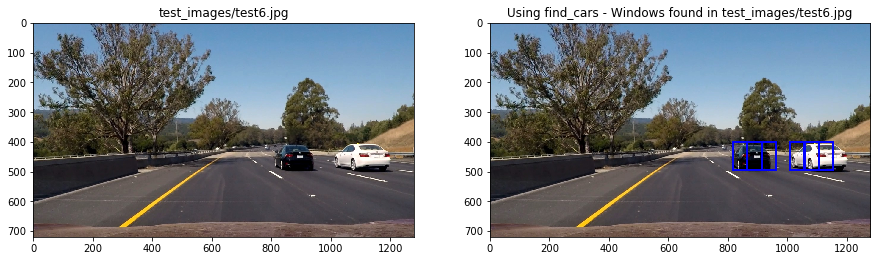

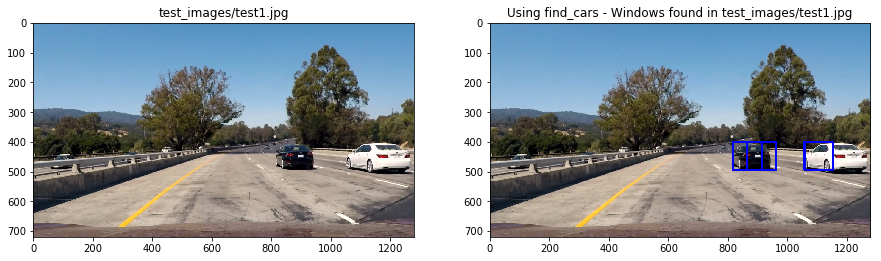

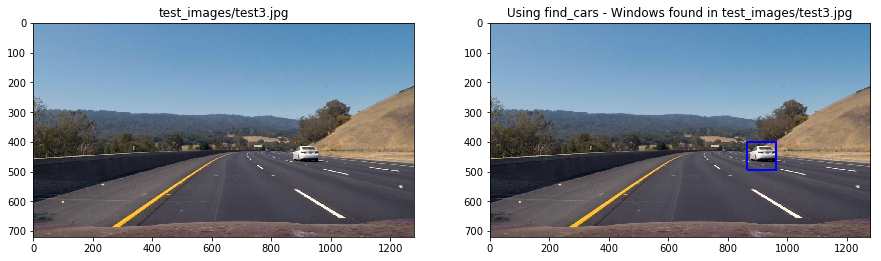

In [22]:
# -----------------------------------------------------------------------------
# Find cars with hog sub-sampling window search

scale = 1.5

for image_path in glob.glob(test_images_path):
    image = mpimg.imread(image_path)

    out_img = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)    
    title1 = image_path
    title2 = 'Using find_cars - Windows found in ' + image_path
    plot_side_by_side(image, title1, out_img, title2)
    

## Heat Maps

In [23]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Heat map
    

# -----------------------------------------------------------------------------
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
# -----------------------------------------------------------------------------
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# -----------------------------------------------------------------------------
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Test Heat Maps with Test Images

/home/jaerock/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


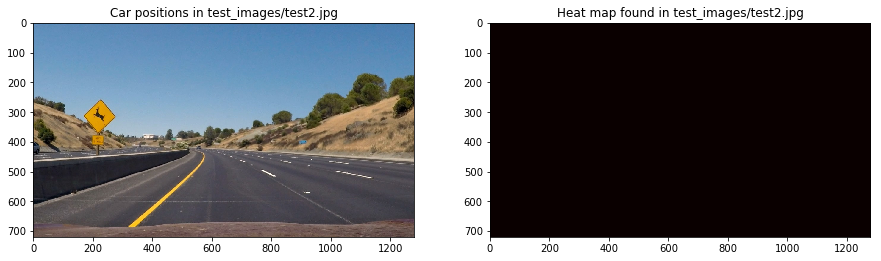

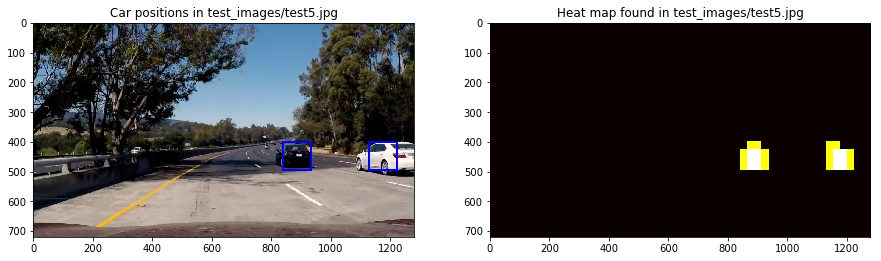

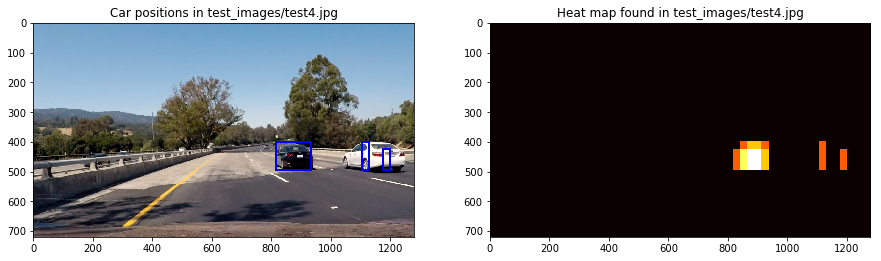

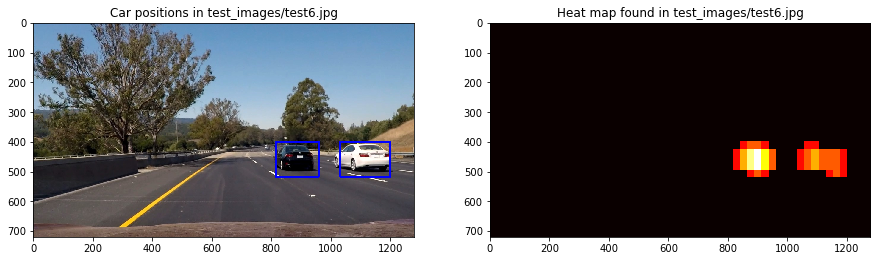

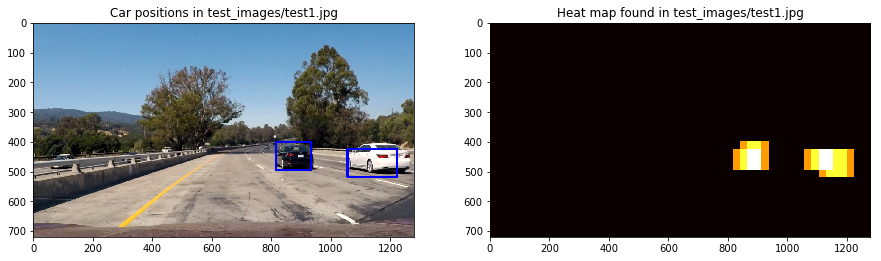

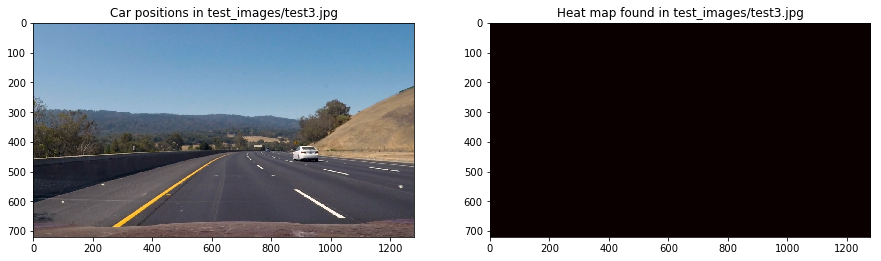

In [24]:

# -----------------------------------------------------------------------------
# Show some examples 
for image_path in glob.glob(test_images_path):
    image = mpimg.imread(image_path)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    hot_windows = find_cars_windows(image, svc, X_scaler)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # -----------------------------------------------------------------------------
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    title1 = 'Car positions in ' + image_path
    title2 = 'Heat map found in ' + image_path
    plot_side_by_side(draw_img, title1, heatmap, title2, cmap='hot')


## Video Implementation

In [25]:
################################################################################
################################################################################
## Video implementation
##
#

################################################################################
# 1. Final video
#

def process_image(image):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    hot_windows = find_cars_windows(image, svc, X_scaler)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # -----------------------------------------------------------------------------
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img


# -----------------------------------------------------------------------------
project_video_filename = 'project_video.mp4'

from moviepy.editor import VideoFileClip
import os

def process_video(src_file_path):
    base = os.path.basename(src_file_path)
    dst_file_path = os.path.splitext(base)[0] + '_processed.mp4'
    src_movie = VideoFileClip(src_file_path, audio=False)
#    src_movie = VideoFileClip(src_file_path, audio=False).subclip(36,43)
    dst_movie = src_movie.fl_image(process_image)
    dst_movie.write_videofile(dst_file_path)
    

## Generate a Video

In [26]:
# -----------------------------------------------------------------------------
process_video(project_video_filename)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [14:45<00:00,  1.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

